In [1]:
#载入预处理
import pandas as pd
import numpy as np

pacifier=pd.read_csv('C:/Users/LENOVO/Desktop/Problem_C_Data/pacifier.tsv',encoding='ISO-8859-1', sep='\t',header=0)
#dryer=pd.read_csv('C:/Users/LENOVO/Desktop/Problem_C_Data/hair_dryer.tsv',encoding='ISO-8859-1', sep='\t', header=0)
#microwave=pd.read_csv('C:/Users/LENOVO/Desktop/Problem_C_Data/microwave.tsv',encoding='ISO-8859-1',sep='\t', header=0)

#保留购买的评论
p0=pacifier[pacifier.verified_purchase.isin(['Y','y'])]

#删除不合理星级
p0=p0[p0.star_rating.isin([1,2,3,4,5])]
#删除冗余列
p0=p0.drop(columns=['marketplace','product_category','review_id','verified_purchase','product_parent','review_headline'])
#排除nan
p0.dropna()
#去重复保留最后出现
p0.drop_duplicates(keep='last')

#统计评论长度
review_length=[]
for i in p0['review_body']:
    #排除nan
    if i is np.nan:
        i="nothing"    
    #统计评论长度
    review_length.append(len(i))
    

    
#装入p0
p0['review_length']=review_length


In [2]:
#NTLK情感分析
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews
 
 
# 分析句子的情感：情感分析是NLP最受欢迎的应用之一。情感分析是指确定一段给定的文本是积极还是消极的过程。
# 有一些场景中，我们还会将“中性“作为第三个选项。情感分析常用于发现人们对于一个特定主题的看法。
 
 
# 定义一个用于提取特征的函数
# 输入一段文本返回形如：{'It': True, 'movie': True, 'amazing': True, 'is': True, 'an': True}
# 返回类型是一个dict
def extract_features(word_list):
    return dict([(word, True) for word in word_list])
 
 
# 我们需要训练数据，这里将用NLTK提供的电影评论数据
if __name__ == '__main__':
    # 加载积极与消极评论
    positive_fileids = movie_reviews.fileids('pos')     # list类型 1000条数据 每一条是一个txt文件
    negative_fileids = movie_reviews.fileids('neg')
    # print(type(positive_fileids), len(negative_fileids))
 
    # 将这些评论数据分成积极评论和消极评论
    # movie_reviews.words(fileids=[f])表示每一个txt文本里面的内容，结果是单词的列表：['films', 'adapted', 'from', 'comic', 'books', 'have', ...]
    # features_positive 结果为一个list
    # 结果形如：[({'shakesp: True, 'limit': True, 'mouth': True, ..., 'such': True, 'prophetic': True}, 'Positive'), ..., ({...}, 'Positive'), ...]
    features_positive = [(extract_features(movie_reviews.words(fileids=[f])), 'Positive') for f in positive_fileids]
    features_negative = [(extract_features(movie_reviews.words(fileids=[f])), 'Negative') for f in negative_fileids]
 
    # 分成训练数据集（80%）和测试数据集（20%）
    threshold_factor = 0.8
    threshold_positive = int(threshold_factor * len(features_positive))  # 800
    threshold_negative = int(threshold_factor * len(features_negative))  # 800
    # 提取特征 800个积极文本800个消极文本构成训练集  200+200构成测试文本
    features_train = features_positive[:threshold_positive] + features_negative[:threshold_negative]
    features_test = features_positive[threshold_positive:] + features_negative[threshold_negative:]
    print("\n训练数据点的数量:", len(features_train))
    print("测试数据点的数量:", len(features_test))
 
    # 训练朴素贝叶斯分类器
    classifier = NaiveBayesClassifier.train(features_train)
    print("\n分类器的准确性:", nltk.classify.util.accuracy(classifier, features_test))
 
    
    # 输入评论
    input_reviews = []
    
    for i in p0['review_body']:
        input_reviews.append(str(i))
        
    scores=[]
    # 运行分类器，获得预测结果
    print("\n预测:")
    for review in input_reviews:
        #print("\n评论:", review)
        probdist = classifier.prob_classify(extract_features(review.split()))
        pred_sentiment = probdist.max()
        # 打印输出
        #print("预测情绪:", pred_sentiment)
        #print("可能性:", round(probdist.prob(pred_sentiment), 2))
        score=0
        score=round(probdist.prob(pred_sentiment), 2)
        if pred_sentiment=='Negative':
            score=-score
        scores.append(score)
    #装入p0    
    p0['score']=scores
    
   
   


训练数据点的数量: 1600
测试数据点的数量: 400

分类器的准确性: 0.735

预测:


In [3]:
#按星级分组
p1=p0['product_title'].groupby(p0['star_rating']).size() 
#print(p1)

#按评论分组
p2=p0['product_title'].groupby(p0['score']<0).size() 
#print(p2)

#生成综合指标comp
p0.eval('cmop=0.4*star_rating+0.6*score',inplace=True)

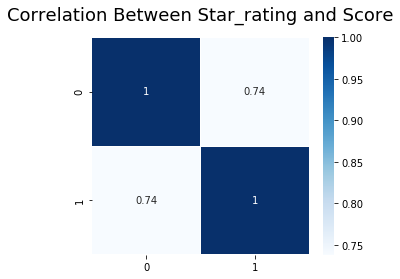

In [4]:
#相关性分析
pc=p0.loc[:,('star_rating','score')]
# 导入可能要用到的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 无量纲化
def dimensionlessProcessing(df_values,df_columns):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    res = scaler.fit_transform(df_values)
    return pd.DataFrame(res,columns=df_columns)

# 求第一列(影响因素)和其它所有列(影响因素)的灰色关联值
def GRA_ONE(data,m=0): # m为参考列
    # 标准化
    data = dimensionlessProcessing(data.values,data.columns)
    # 参考数列
    std = data.iloc[:,m]
    # 比较数列
    ce = data.copy()
    
    n = ce.shape[0]
    m = ce.shape[1]
    
    # 与参考数列比较，相减
    grap = np.zeros([n,m])
    for i in range(m):
        for j in range(n):
            grap[j,i] = abs(ce.iloc[j,i] - std[j])
            
    # 取出矩阵中的最大值和最小值
    mmax = np.amax(grap)
    mmin = np.amin(grap)
    ρ = 0.5 # 灰色分辨系数
    
    # 计算值
    grap = pd.DataFrame(grap).applymap(lambda x:(mmin+ρ*mmax)/(x+ρ*mmax))
    
    # 求均值，得到灰色关联值
    RT = grap.mean(axis=0)
    return pd.Series(RT)

# 调用GRA_ONE，求得所有因素之间的灰色关联值
def GRA(data):
    list_columns = np.arange(data.shape[1])
    df_local = pd.DataFrame(columns=list_columns)
    for i in np.arange(data.shape[1]):
        df_local.iloc[:,i] = GRA_ONE(data,m=i)
    return df_local

data_gra = GRA(pc)
data_gra

# 结果可视化
import seaborn as sns # 可视化图形调用库
import matplotlib.pyplot as plt
%matplotlib inline

def ShowGRAHeatMap(data):
    # 色彩集
    colormap = plt.cm.Blues
    plt.figure(figsize=(5,4))
    plt.title('Correlation Between Star_rating and Score',y=1.05,size=18)
    sns.heatmap(data.astype(float),linewidths=0.1,vmax=1.0,square=True,\
               cmap=colormap,linecolor='white',annot=True)
    plt.show()

ShowGRAHeatMap(data_gra)


In [5]:
#改变时间格式
from datetime import datetime
a=[]
for date in p0['review_date']:
    a.append(datetime.strptime(date,'%m/%d/%Y'))
p0['review_date']=a


In [16]:
import wordcloud

w=wordcloud.WordCloud(background_color="white")   #——1.创建对象
txt=''
for state in p0['review_body']:
    txt+=str(state)
w.generate(txt)   #2.加载文本
w.to_file('C:/Users/LENOVO/Desktop/cy1.png')  #3.输出文件
